<a href="https://colab.research.google.com/github/ShiyuMiao/Leaf_Map/blob/main/%E7%AE%A1%E7%BA%BF%E8%87%AA%E5%8A%A8%E5%AF%BB%E8%B7%AF%E4%B8%93%E5%88%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


PIPELINE ROUTING OPTIMIZATION RESULTS

Pipeline: Hot Water Supply
Start Point: (2.0, 2.0, 1.0)
End Point: (25.0, 25.0, 15.0)
Total Length: 68.00 m
Number of Elbows: 4
Number of Waypoints: 69

Path Segments:
No.   Direction  Length(m)    From                 To                  
----------------------------------------------------------------------
1     X          1.00         (2.0,2.0,1.0)        (1.0,2.0,1.0)       
2     Y          1.00         (1.0,2.0,1.0)        (1.0,3.0,1.0)       
3     Y          1.00         (1.0,3.0,1.0)        (1.0,4.0,1.0)       
4     Y          1.00         (1.0,4.0,1.0)        (1.0,5.0,1.0)       
5     Y          1.00         (1.0,5.0,1.0)        (1.0,6.0,1.0)       
6     Y          1.00         (1.0,6.0,1.0)        (1.0,7.0,1.0)       
7     Y          1.00         (1.0,7.0,1.0)        (1.0,8.0,1.0)       
8     Y          1.00         (1.0,8.0,1.0)        (1.0,9.0,1.0)       
9     Y          1.00         (1.0,9.0,1.0)        (1.0,10.0,1.0)      
1

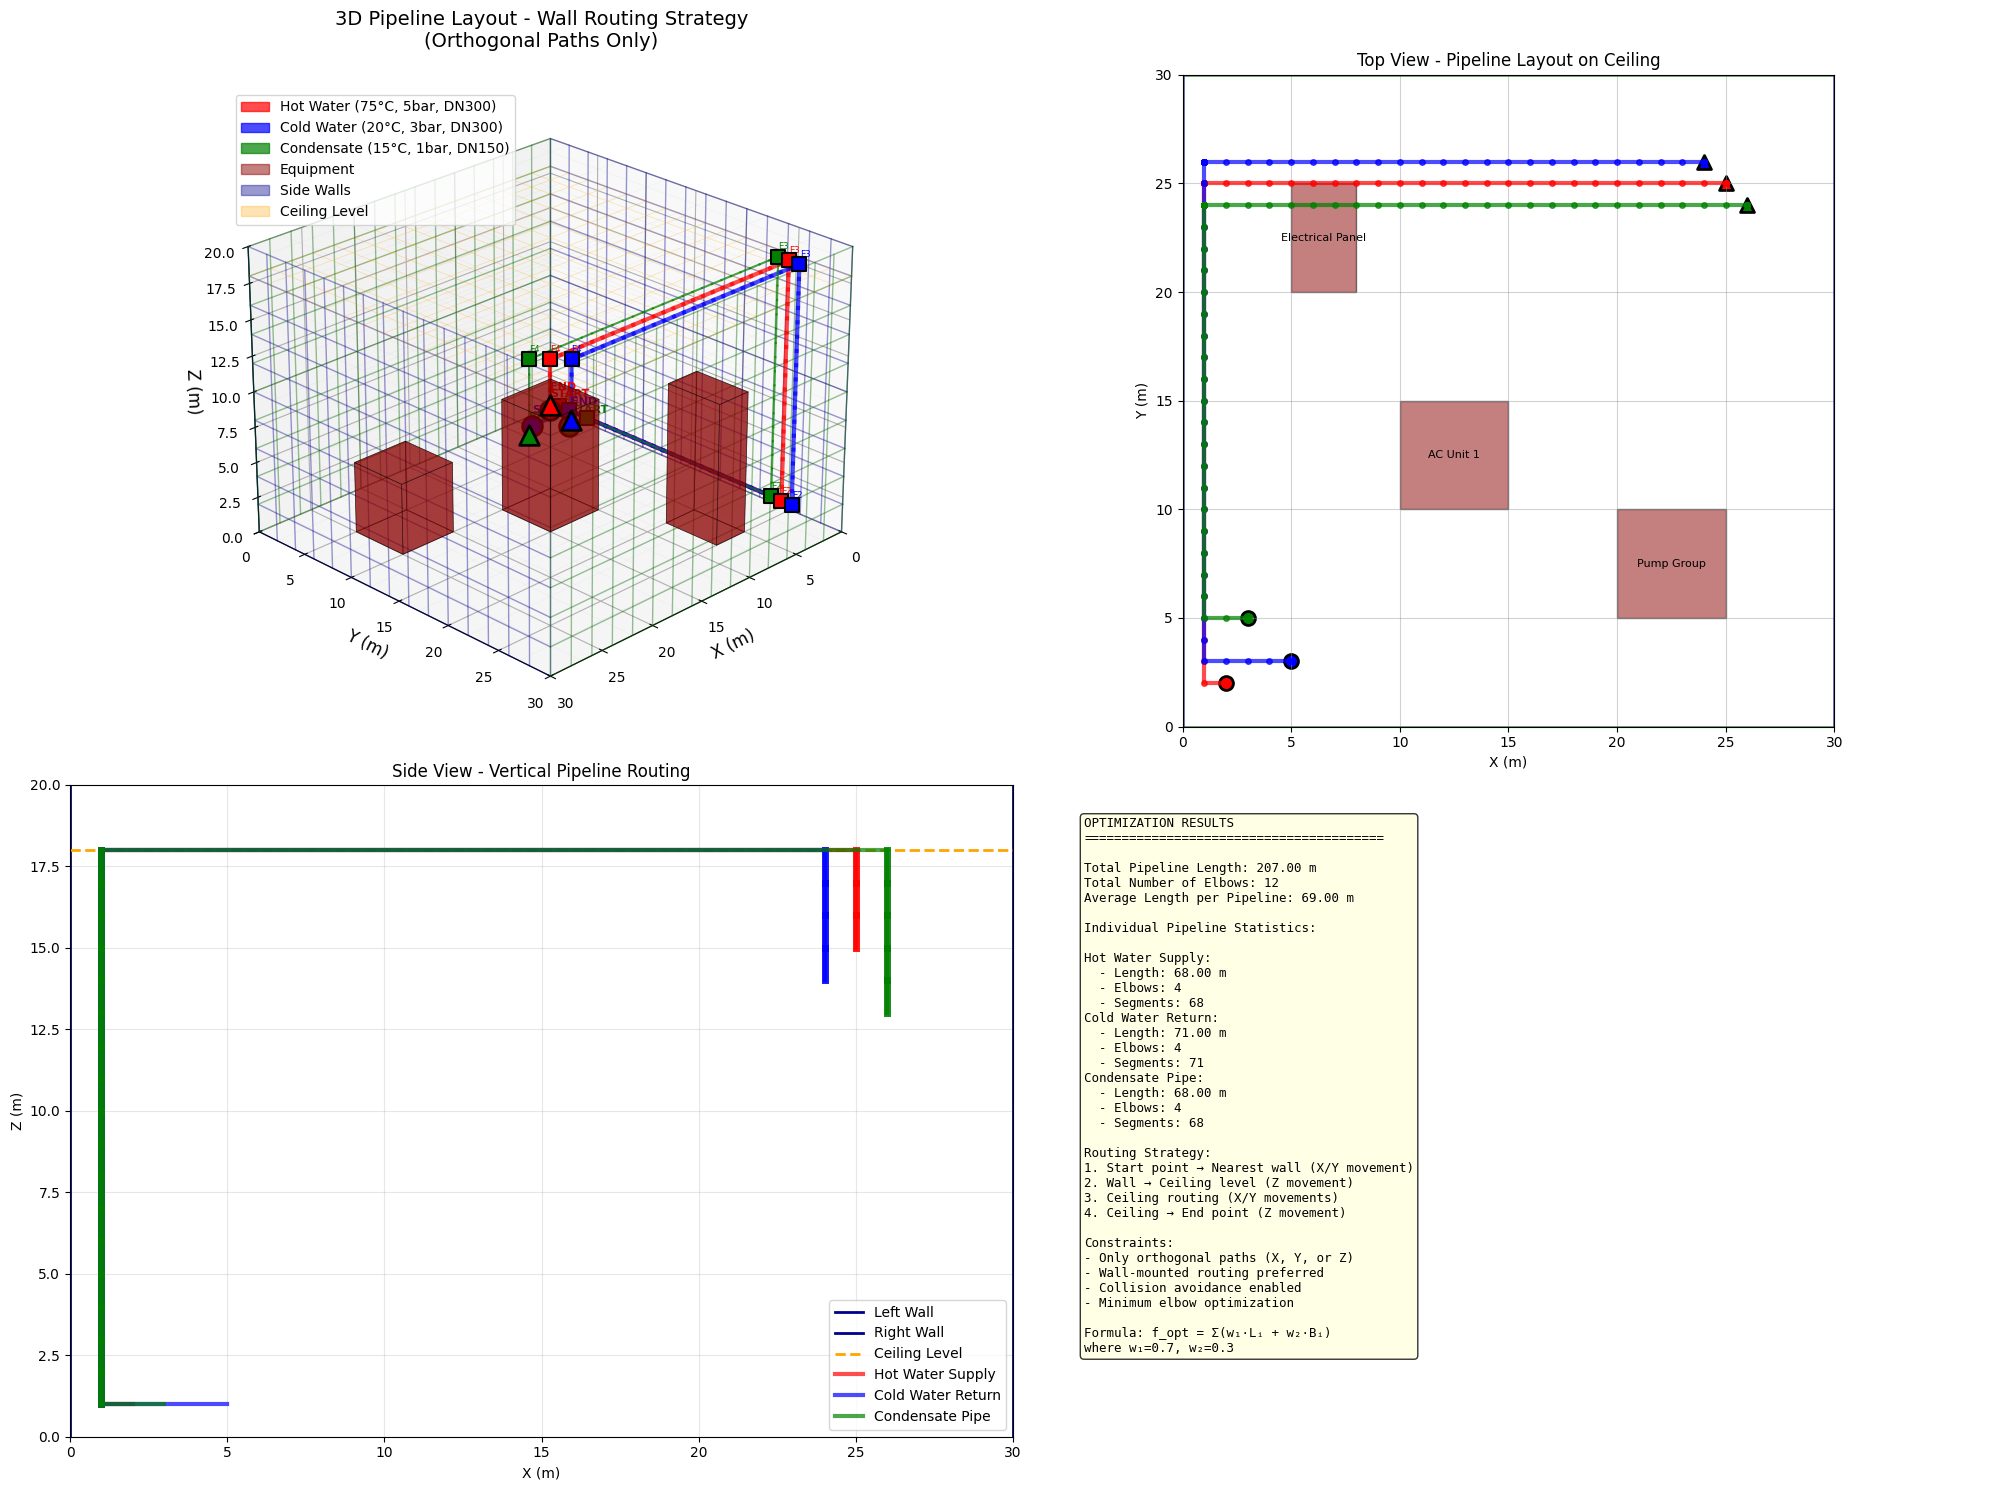

In [2]:
"""
Pipeline Layout Optimization Visualization Program
Enhanced version with wall routing and orthogonal paths
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.patches as mpatches
from collections import deque

# Configure matplotlib for better display
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False


class SpaceGrid:
    """Space grid class for path planning"""
    def __init__(self, width, height, depth, grid_size=1.0):
        self.width = width
        self.height = height
        self.depth = depth
        self.grid_size = grid_size

        # Calculate grid dimensions
        self.nx = int(width / grid_size)
        self.ny = int(height / grid_size)
        self.nz = int(depth / grid_size)

        # Create grid (0=free, 1=obstacle)
        self.grid = np.zeros((self.nx, self.ny, self.nz))

    def add_obstacle(self, min_point, max_point):
        """Add obstacle to grid"""
        x1, y1, z1 = [int(p / self.grid_size) for p in min_point]
        x2, y2, z2 = [int(p / self.grid_size) for p in max_point]

        # Ensure indices are within bounds
        x1, x2 = max(0, x1), min(self.nx, x2)
        y1, y2 = max(0, y1), min(self.ny, y2)
        z1, z2 = max(0, z1), min(self.nz, z2)

        self.grid[x1:x2, y1:y2, z1:z2] = 1

    def is_free(self, x, y, z):
        """Check if grid point is free"""
        if 0 <= x < self.nx and 0 <= y < self.ny and 0 <= z < self.nz:
            return self.grid[x, y, z] == 0
        return False

    def find_wall_routing_path(self, start, end):
        """Find path along walls (engineering practical path)"""
        # Convert coordinates to grid indices
        start_idx = [int(p / self.grid_size) for p in start]
        end_idx = [int(p / self.grid_size) for p in end]

        path = []
        current = start_idx

        # Step 1: Move horizontally to wall (choose nearest wall)
        if current[0] <= self.nx / 2:
            wall_x = 1  # Near left wall
        else:
            wall_x = self.nx - 2  # Near right wall

        # Move to wall position along X axis
        x_path = self.find_straight_path(current, [wall_x, current[1], current[2]], 'x')
        path.extend(x_path)
        if x_path:
            current = x_path[-1]

        # Step 2: Move along wall to correct Y position
        y_path = self.find_straight_path(current, [current[0], end_idx[1], current[2]], 'y')
        path.extend(y_path[1:] if len(y_path) > 1 else [])
        if y_path:
            current = y_path[-1]

        # Step 3: Move up along wall to ceiling
        ceiling_z = self.nz - 2
        z_up_path = self.find_straight_path(current, [current[0], current[1], ceiling_z], 'z')
        path.extend(z_up_path[1:] if len(z_up_path) > 1 else [])
        if z_up_path:
            current = z_up_path[-1]

        # Step 4: Move along ceiling to destination X position
        ceiling_x_path = self.find_straight_path(current, [end_idx[0], current[1], current[2]], 'x')
        path.extend(ceiling_x_path[1:] if len(ceiling_x_path) > 1 else [])
        if ceiling_x_path:
            current = ceiling_x_path[-1]

        # Step 5: Move along ceiling to destination Y position
        ceiling_y_path = self.find_straight_path(current, [current[0], end_idx[1], current[2]], 'y')
        path.extend(ceiling_y_path[1:] if len(ceiling_y_path) > 1 else [])
        if ceiling_y_path:
            current = ceiling_y_path[-1]

        # Step 6: Move down to final position if needed
        if end_idx[2] < ceiling_z:
            z_down_path = self.find_straight_path(current, end_idx, 'z')
            path.extend(z_down_path[1:] if len(z_down_path) > 1 else [])

        # Convert back to real coordinates
        real_path = [[p[0] * self.grid_size, p[1] * self.grid_size, p[2] * self.grid_size]
                     for p in path]

        return real_path

    def find_straight_path(self, start, end, axis):
        """Find straight path along single axis"""
        path = []
        current = list(start)

        if axis == 'x':
            step = 1 if end[0] > start[0] else -1
            for x in range(start[0], end[0] + step, step):
                current[0] = x
                if self.is_free(current[0], current[1], current[2]):
                    path.append(list(current))
                else:
                    break
        elif axis == 'y':
            step = 1 if end[1] > start[1] else -1
            for y in range(start[1], end[1] + step, step):
                current[1] = y
                if self.is_free(current[0], current[1], current[2]):
                    path.append(list(current))
                else:
                    break
        elif axis == 'z':
            step = 1 if end[2] > start[2] else -1
            for z in range(start[2], end[2] + step, step):
                current[2] = z
                if self.is_free(current[0], current[1], current[2]):
                    path.append(list(current))
                else:
                    break

        return path if path else [start]


def calculate_path_info(path):
    """Calculate path information"""
    total_length = 0
    segments = []
    elbows = 0

    for i in range(len(path) - 1):
        # Calculate segment length
        segment_length = np.sqrt(sum((path[i+1][j] - path[i][j])**2 for j in range(3)))
        total_length += segment_length

        # Determine direction
        direction = None
        if path[i+1][0] != path[i][0]:
            direction = 'X'
        elif path[i+1][1] != path[i][1]:
            direction = 'Y'
        elif path[i+1][2] != path[i][2]:
            direction = 'Z'

        segments.append({
            'start': path[i],
            'end': path[i+1],
            'length': segment_length,
            'direction': direction
        })

        # Count elbows
        if i > 0:
            v1 = np.array(path[i]) - np.array(path[i-1])
            v2 = np.array(path[i+1]) - np.array(path[i])
            if not np.array_equal(v1, v2):
                elbows += 1

    return {
        'total_length': total_length,
        'segments': segments,
        'elbows': elbows,
        'waypoints': len(path)
    }


def print_pipeline_info(pipeline_name, path_info, start, end):
    """Print detailed pipeline information"""
    print(f"\n{'='*60}")
    print(f"Pipeline: {pipeline_name}")
    print(f"{'='*60}")
    print(f"Start Point: ({start[0]:.1f}, {start[1]:.1f}, {start[2]:.1f})")
    print(f"End Point: ({end[0]:.1f}, {end[1]:.1f}, {end[2]:.1f})")
    print(f"Total Length: {path_info['total_length']:.2f} m")
    print(f"Number of Elbows: {path_info['elbows']}")
    print(f"Number of Waypoints: {path_info['waypoints']}")
    print(f"\nPath Segments:")
    print(f"{'No.':<5} {'Direction':<10} {'Length(m)':<12} {'From':<20} {'To':<20}")
    print("-" * 70)

    for i, segment in enumerate(path_info['segments']):
        start_str = f"({segment['start'][0]:.1f},{segment['start'][1]:.1f},{segment['start'][2]:.1f})"
        end_str = f"({segment['end'][0]:.1f},{segment['end'][1]:.1f},{segment['end'][2]:.1f})"
        print(f"{i+1:<5} {segment['direction']:<10} {segment['length']:<12.2f} {start_str:<20} {end_str:<20}")


def create_comprehensive_3d_visualization():
    """Create comprehensive 3D space visualization with wall routing"""
    fig = plt.figure(figsize=(20, 15))

    # Main 3D view
    ax1 = fig.add_subplot(221, projection='3d')

    # Space parameters
    space_width = 30
    space_height = 30
    space_depth = 20
    grid_size = 1.0

    # Create space grid
    space_grid = SpaceGrid(space_width, space_height, space_depth, grid_size)

    # 1. Draw space grid with walls highlighted
    # Draw walls with thicker lines
    # Left wall (X=0)
    for y in range(0, space_height + 1, 2):
        ax1.plot([0, 0], [y, y], [0, space_depth], 'darkblue', alpha=0.4, linewidth=1)
    for z in range(0, space_depth + 1, 2):
        ax1.plot([0, 0], [0, space_height], [z, z], 'darkblue', alpha=0.4, linewidth=1)

    # Right wall (X=width)
    for y in range(0, space_height + 1, 2):
        ax1.plot([space_width, space_width], [y, y], [0, space_depth], 'darkblue', alpha=0.4, linewidth=1)
    for z in range(0, space_depth + 1, 2):
        ax1.plot([space_width, space_width], [0, space_height], [z, z], 'darkblue', alpha=0.4, linewidth=1)

    # Front wall (Y=0)
    for x in range(0, space_width + 1, 2):
        ax1.plot([x, x], [0, 0], [0, space_depth], 'darkgreen', alpha=0.4, linewidth=1)
    for z in range(0, space_depth + 1, 2):
        ax1.plot([0, space_width], [0, 0], [z, z], 'darkgreen', alpha=0.4, linewidth=1)

    # Back wall (Y=height)
    for x in range(0, space_width + 1, 2):
        ax1.plot([x, x], [space_height, space_height], [0, space_depth], 'darkgreen', alpha=0.4, linewidth=1)
    for z in range(0, space_depth + 1, 2):
        ax1.plot([0, space_width], [space_height, space_height], [z, z], 'darkgreen', alpha=0.4, linewidth=1)

    # Ceiling (Z=depth-2)
    ceiling_z = space_depth - 2
    for x in range(0, space_width + 1, 2):
        ax1.plot([x, x], [0, space_height], [ceiling_z, ceiling_z], 'orange', alpha=0.3, linewidth=0.5)
    for y in range(0, space_height + 1, 2):
        ax1.plot([0, space_width], [y, y], [ceiling_z, ceiling_z], 'orange', alpha=0.3, linewidth=0.5)

    # Regular grid
    for z in range(0, space_depth + 1, 5):
        for x in range(2, space_width - 1, 5):
            ax1.plot([x, x], [0, space_height], [z, z], 'gray', alpha=0.1, linewidth=0.3)
        for y in range(2, space_height - 1, 5):
            ax1.plot([0, space_width], [y, y], [z, z], 'gray', alpha=0.1, linewidth=0.3)

    # 2. Add obstacles
    obstacles = [
        {'name': 'AC Unit 1', 'min': [10, 10, 0], 'max': [15, 15, 8]},
        {'name': 'Pump Group', 'min': [20, 5, 0], 'max': [25, 10, 5]},
        {'name': 'Electrical Panel', 'min': [5, 20, 0], 'max': [8, 25, 10]}
    ]

    # Add obstacles to grid
    for obstacle in obstacles:
        space_grid.add_obstacle(obstacle['min'], obstacle['max'])
        draw_box(ax1, obstacle['min'], obstacle['max'], color='darkred', alpha=0.5)

    # 3. Draw pipelines with wall routing
    pipelines = [
        {
            'name': 'Hot Water Supply',
            'start': [2, 2, 1],
            'end': [25, 25, 15],
            'color': 'red',
            'diameter': 0.3,
            'temperature': 75,
            'pressure': 5
        },
        {
            'name': 'Cold Water Return',
            'start': [5, 3, 1],
            'end': [24, 26, 14],
            'color': 'blue',
            'diameter': 0.3,
            'temperature': 20,
            'pressure': 3
        },
        {
            'name': 'Condensate Pipe',
            'start': [3, 5, 1],
            'end': [26, 24, 13],
            'color': 'green',
            'diameter': 0.15,
            'temperature': 15,
            'pressure': 1
        }
    ]

    # Calculate path for each pipeline and print info
    print("\nPIPELINE ROUTING OPTIMIZATION RESULTS")
    print("="*80)

    all_path_info = []

    for pipeline in pipelines:
        path = space_grid.find_wall_routing_path(
            pipeline['start'],
            pipeline['end']
        )
        pipeline['path'] = path

        # Calculate and print path information
        path_info = calculate_path_info(path)
        print_pipeline_info(pipeline['name'], path_info, pipeline['start'], pipeline['end'])

        all_path_info.append({
            'name': pipeline['name'],
            'info': path_info
        })

        draw_optimized_pipeline_with_labels(ax1, pipeline)

    # Print summary
    print("\n" + "="*80)
    print("OPTIMIZATION SUMMARY")
    print("="*80)
    total_length = sum(info['info']['total_length'] for info in all_path_info)
    total_elbows = sum(info['info']['elbows'] for info in all_path_info)
    print(f"Total Pipeline Length: {total_length:.2f} m")
    print(f"Total Number of Elbows: {total_elbows}")
    print(f"Average Elbows per Pipeline: {total_elbows/len(pipelines):.1f}")

    # 4. Add labels and title
    ax1.set_xlabel('X (m)', fontsize=12)
    ax1.set_ylabel('Y (m)', fontsize=12)
    ax1.set_zlabel('Z (m)', fontsize=12)
    ax1.set_title('3D Pipeline Layout - Wall Routing Strategy\n(Orthogonal Paths Only)', fontsize=14, pad=20)

    # Set viewing angle
    ax1.view_init(elev=25, azim=45)

    # Set axis limits
    ax1.set_xlim(0, space_width)
    ax1.set_ylim(0, space_height)
    ax1.set_zlim(0, space_depth)

    # Add legend
    legend_elements = [
        mpatches.Patch(color='red', alpha=0.7, label='Hot Water (75°C, 5bar, DN300)'),
        mpatches.Patch(color='blue', alpha=0.7, label='Cold Water (20°C, 3bar, DN300)'),
        mpatches.Patch(color='green', alpha=0.7, label='Condensate (15°C, 1bar, DN150)'),
        mpatches.Patch(color='darkred', alpha=0.5, label='Equipment'),
        mpatches.Patch(color='darkblue', alpha=0.4, label='Side Walls'),
        mpatches.Patch(color='orange', alpha=0.3, label='Ceiling Level')
    ]
    ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.02, 0.98))

    # Top view
    ax2 = fig.add_subplot(222)
    draw_top_view(ax2, space_width, space_height, obstacles, pipelines)

    # Side view
    ax3 = fig.add_subplot(223)
    draw_side_view(ax3, space_width, space_depth, pipelines)

    # Optimization results
    ax4 = fig.add_subplot(224)
    draw_optimization_results(ax4, all_path_info, total_length, total_elbows)

    plt.tight_layout()
    return fig


def draw_optimized_pipeline_with_labels(ax, pipeline):
    """Draw optimized pipeline path with start/end labels"""
    path = pipeline['path']

    # Draw pipeline path segments
    for i in range(len(path) - 1):
        x = [path[i][0], path[i+1][0]]
        y = [path[i][1], path[i+1][1]]
        z = [path[i][2], path[i+1][2]]

        ax.plot(x, y, z,
                color=pipeline['color'],
                linewidth=pipeline['diameter'] * 10,
                alpha=0.7)

    # Mark and label start point
    ax.scatter(*pipeline['start'], color=pipeline['color'], s=200,
               marker='o', edgecolor='black', linewidth=2)
    ax.text(pipeline['start'][0], pipeline['start'][1], pipeline['start'][2] + 1,
            'START', fontsize=8, color=pipeline['color'], fontweight='bold')

    # Mark and label end point
    ax.scatter(*pipeline['end'], color=pipeline['color'], s=200,
               marker='^', edgecolor='black', linewidth=2)
    ax.text(pipeline['end'][0], pipeline['end'][1], pipeline['end'][2] + 1,
            'END', fontsize=8, color=pipeline['color'], fontweight='bold')

    # Mark elbows (turning points)
    elbow_count = 0
    for i in range(1, len(path) - 1):
        # Check if it's a turning point
        v1 = np.array(path[i]) - np.array(path[i-1])
        v2 = np.array(path[i+1]) - np.array(path[i])

        if not np.array_equal(v1, v2):  # Direction changed, it's an elbow
            elbow_count += 1
            ax.scatter(*path[i], color=pipeline['color'], s=100,
                      marker='s', edgecolor='black', linewidth=1.5)
            # Label elbows
            ax.text(path[i][0], path[i][1], path[i][2] + 0.5,
                   f'E{elbow_count}', fontsize=6, color=pipeline['color'])


def draw_box(ax, min_point, max_point, color='red', alpha=0.3):
    """Draw 3D box (obstacle)"""
    vertices = [
        [min_point[0], min_point[1], min_point[2]],
        [max_point[0], min_point[1], min_point[2]],
        [max_point[0], max_point[1], min_point[2]],
        [min_point[0], max_point[1], min_point[2]],
        [min_point[0], min_point[1], max_point[2]],
        [max_point[0], min_point[1], max_point[2]],
        [max_point[0], max_point[1], max_point[2]],
        [min_point[0], max_point[1], max_point[2]]
    ]

    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],
        [vertices[4], vertices[5], vertices[6], vertices[7]],
        [vertices[0], vertices[1], vertices[5], vertices[4]],
        [vertices[2], vertices[3], vertices[7], vertices[6]],
        [vertices[1], vertices[2], vertices[6], vertices[5]],
        [vertices[4], vertices[7], vertices[3], vertices[0]]
    ]

    ax.add_collection3d(Poly3DCollection(faces, alpha=alpha, facecolor=color,
                                        edgecolor='black', linewidth=0.5))


def draw_top_view(ax, width, height, obstacles, pipelines):
    """Draw top view of the layout"""
    # Draw grid
    for x in range(0, width + 1, 5):
        ax.axvline(x, color='gray', alpha=0.3, linewidth=0.5)
    for y in range(0, height + 1, 5):
        ax.axhline(y, color='gray', alpha=0.3, linewidth=0.5)

    # Highlight walls
    ax.axvline(0, color='darkblue', linewidth=2, alpha=0.6)
    ax.axvline(width, color='darkblue', linewidth=2, alpha=0.6)
    ax.axhline(0, color='darkgreen', linewidth=2, alpha=0.6)
    ax.axhline(height, color='darkgreen', linewidth=2, alpha=0.6)

    # Draw obstacles
    for obs in obstacles:
        rect = plt.Rectangle((obs['min'][0], obs['min'][1]),
                           obs['max'][0] - obs['min'][0],
                           obs['max'][1] - obs['min'][1],
                           facecolor='darkred', alpha=0.5, edgecolor='black')
        ax.add_patch(rect)
        ax.text((obs['min'][0] + obs['max'][0])/2,
                (obs['min'][1] + obs['max'][1])/2,
                obs['name'], ha='center', va='center', fontsize=8)

    # Draw pipeline paths (top view)
    for pipeline in pipelines:
        path = pipeline['path']
        x_coords = [p[0] for p in path]
        y_coords = [p[1] for p in path]
        ax.plot(x_coords, y_coords, color=pipeline['color'],
                linewidth=3, marker='o', markersize=4, alpha=0.7)

        # Mark start and end
        ax.scatter(pipeline['start'][0], pipeline['start'][1],
                  color=pipeline['color'], s=100, marker='o', edgecolor='black', linewidth=2)
        ax.scatter(pipeline['end'][0], pipeline['end'][1],
                  color=pipeline['color'], s=100, marker='^', edgecolor='black', linewidth=2)

    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.set_xlabel('X (m)', fontsize=10)
    ax.set_ylabel('Y (m)', fontsize=10)
    ax.set_title('Top View - Pipeline Layout on Ceiling', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')


def draw_side_view(ax, width, depth, pipelines):
    """Draw side view showing vertical paths"""
    ax.set_xlim(0, width)
    ax.set_ylim(0, depth)

    # Draw walls and ceiling
    ax.axvline(0, color='darkblue', linewidth=2, label='Left Wall')
    ax.axvline(width, color='darkblue', linewidth=2, label='Right Wall')
    ax.axhline(depth-2, color='orange', linewidth=2, linestyle='--', label='Ceiling Level')

    # Draw vertical paths for each pipeline
    for i, pipeline in enumerate(pipelines):
        path = pipeline['path']
        # Extract X-Z projection
        x_coords = [p[0] for p in path]
        z_coords = [p[2] for p in path]

        # Draw path
        ax.plot(x_coords, z_coords, color=pipeline['color'],
               linewidth=3, alpha=0.7, label=pipeline['name'])

        # Mark vertical segments
        for j in range(len(path) - 1):
            if path[j][2] != path[j+1][2] and path[j][0] == path[j+1][0]:  # Vertical segment
                ax.plot([path[j][0], path[j+1][0]], [path[j][2], path[j+1][2]],
                       color=pipeline['color'], linewidth=5, alpha=0.9)

    ax.set_xlabel('X (m)', fontsize=10)
    ax.set_ylabel('Z (m)', fontsize=10)
    ax.set_title('Side View - Vertical Pipeline Routing', fontsize=12)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)


def draw_optimization_results(ax, all_path_info, total_length, total_elbows):
    """Draw optimization results"""
    results_text = f"""OPTIMIZATION RESULTS
{'='*40}

Total Pipeline Length: {total_length:.2f} m
Total Number of Elbows: {total_elbows}
Average Length per Pipeline: {total_length/len(all_path_info):.2f} m

Individual Pipeline Statistics:
"""

    for info in all_path_info:
        results_text += f"\n{info['name']}:"
        results_text += f"\n  - Length: {info['info']['total_length']:.2f} m"
        results_text += f"\n  - Elbows: {info['info']['elbows']}"
        results_text += f"\n  - Segments: {len(info['info']['segments'])}"

    results_text += f"""

Routing Strategy:
1. Start point → Nearest wall (X/Y movement)
2. Wall → Ceiling level (Z movement)
3. Ceiling routing (X/Y movements)
4. Ceiling → End point (Z movement)

Constraints:
- Only orthogonal paths (X, Y, or Z)
- Wall-mounted routing preferred
- Collision avoidance enabled
- Minimum elbow optimization

Formula: f_opt = Σ(w₁·Lᵢ + w₂·Bᵢ)
where w₁={0.7}, w₂={0.3}"""

    ax.text(0.05, 0.95, results_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    ax.axis('off')


def main():
    """Main function"""
    # Create comprehensive 3D visualization
    fig1 = create_comprehensive_3d_visualization()
    plt.savefig('pipeline_wall_routing_3d.png', dpi=300, bbox_inches='tight')

    plt.show()


if __name__ == "__main__":
    main()
